In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from transformer_lens import HookedTransformer, utils
import circuitsvis as cv
from fancy_einsum import einsum
import transformer_lens.utils as utils
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
from model import create_model
from dataset import MedianDataset

#### Initiliaze some functions to calculate the performance and get some visualization

In [3]:
def loss_fn(logits, y_batch, return_per_token=False):
    logits = logits[:, -1, :]
    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, y_batch).squeeze()

    if return_per_token:
        return -correct_log_probs
    return -correct_log_probs.mean()

def acc_fn(logits, y_batch, return_per_token=False):
    pred_logits = logits[:, -1, :]
    pred_tokens = torch.argmax(pred_logits, dim=1)
    accuracy = (pred_tokens == y_batch).float()

    if return_per_token:
        return accuracy
    return accuracy.mean().item()


def line(tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
  if isinstance(tensor, torch.Tensor):
    tensor = tensor.detach().numpy()
  labels = {"y":yaxis, "x":xaxis}
  fig = px.line(tensor, labels=labels, **kwargs)
  if line_labels:
      for c, label in enumerate(line_labels):
          fig.data[c].name = label
  fig.show()

def line2(tensor1, tensor2=None, line_labels=None, yaxis="", xaxis="", colors=None, **kwargs):
    # Convert PyTorch tensors to numpy if necessary
    if isinstance(tensor1, torch.Tensor):
        tensor1 = tensor1.detach().numpy()
    if tensor2 is not None and isinstance(tensor2, torch.Tensor):
        tensor2 = tensor2.detach().numpy()

    labels = {"y": yaxis, "x": xaxis}
    
    # Initialize the figure as a blank figure using go.Figure
    fig = go.Figure()

    # Add the first dataset (tensor1) to the plot
    fig.add_trace(go.Scatter(y=tensor1, mode='lines', name=line_labels[0] if line_labels else "Line 1",
                             line=dict(color=colors[0] if colors else None)))

    # If the second dataset (tensor2) is provided, add it to the same plot
    if tensor2 is not None:
        fig.add_trace(go.Scatter(y=tensor2, mode='lines', name=line_labels[1] if line_labels else "Line 2",
                                 line=dict(color=colors[1] if colors else None)))

    # Update layout with axis labels
    fig.update_layout(
        xaxis_title=xaxis,
        yaxis_title=yaxis
    )

    # Show the plot
    fig.show()

### The Model

Our task is really basic and simple. We have a list of numbers and we want to predict the median of them. In this task I must say I was highly influenced by CallumMcDougall TakeMax problem and Neel Nanda's 200 problems in MI. 

For this task, I used a simple transformer model with only one layer and one head. This made the model very simple and easy to train. I hope that, due to the model's small size and simplicity, interpreting the model weights will be equally simple.

##### Upload the model

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
filename = "median_model4.pt"

# # Check we can load in the model
model = create_model(
    max_num=50,
    seq_len=7,
    seed=0,
    d_model=32*1,
    d_head=32,
    n_layers=1,
    n_heads=1,
    normalization_type="LN",
    d_mlp=None
)
model.load_state_dict(torch.load(filename))
cfg = model.cfg

cuda


C:\Users\i_kon\AppData\Local\Temp\ipykernel_21216\3004283550.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


#### a simple prediction function

In [5]:
def predict(toks, model, device='cuda',show_result=False,return_loss=False):
    if isinstance(toks, str):
        toks = toks.split(',')
        toks = [int(t) for t in toks]
        query_tensor = torch.tensor([toks], dtype=torch.long).to(device)
    else:
        query_tensor = toks

    model.eval()
    with torch.no_grad():
        output = model(query_tensor)
        predicted_token_idx = torch.argmax(output[:, -1, :], dim=-1)
        if return_loss or show_result:
            target_token_tensor = query_tensor.median(dim=1).values.unsqueeze(1)
            loss = loss_fn(output, target_token_tensor,return_per_token=True)
            if show_result:
                print(f"Predicted: {predicted_token_idx}")
                print(f"Target: {target_token_tensor.squeeze()}")
                print(f"Loss: {loss}")
            return predicted_token_idx, loss
    return predicted_token_idx

In [6]:
# predict("1,45,32,12,34,14,18",model,show_result=True)

dataset = MedianDataset(size=15, max_num=cfg.d_vocab,length=cfg.n_ctx, seed=42).to(DEVICE)
_ = predict(dataset[:,:-1],model,show_result=True)

Predicted: tensor([26, 13, 22, 23, 29, 26, 27, 27, 28, 11, 33, 14, 32, 39, 17],
       device='cuda:0')
Target: tensor([26, 13, 22, 23, 29, 26, 27, 27, 28, 11, 33, 14, 32, 39, 17],
       device='cuda:0')
Loss: tensor([4.9351e-05, 7.1332e-02, 3.1257e-03, 2.5391e-05, 3.2894e-02, 1.1026e-04,
        3.3969e-03, 1.6034e-03, 1.7708e-03, 3.8450e-04, 1.4642e-02, 1.5910e-01,
        2.8547e-02, 1.9073e-06, 2.8474e-02], device='cuda:0')


#### some ablation code

In [7]:
from functools import partial

def predict_with_ablation(queries, model,device='cuda', mode="write", ablation_configs=None, return_loss=True):
    
    def ablation_hook_fn(activation, hook, head, positions):
        # Assuming activation shape: [batch_size, seq_len, num_heads, head_dim]
        if positions is None:
            # Ablate the entire head across all positions
            mean_values = activation[:, :, head, :].mean(dim=1, keepdim=True)
            activation[:, :, head, :] = mean_values.repeat(1, activation.size(1), 1)
        else:
            # Ablate only specified positions in the head
            for pos in positions:
                mean_values = activation[:, pos, head, :].mean(dim=0, keepdim=True)
                activation[:, pos, head, :] = mean_values.expand(activation.size(0), -1)
        return activation

    # Configure hooks for each specified ablation configuration
    model.reset_hooks()
    for config in ablation_configs:
        layer = config["layer"]
        head = config["head"]
        positions = config.get("positions", None)

        hook_name = utils.get_act_name("result", layer) if mode == "write" else utils.get_act_name("qkv", layer)

        # Define a closure to retain the current head and positions for each ablation config
        # def hook_closure(activation, hook, head=head, positions=positions):
        #     return ablation_hook_fn(activation, hook, head, positions)
        
        # model.add_hook(hook_name, hook_closure)
        hook_fn = partial(ablation_hook_fn, head=head, positions=positions)
        model.add_hook(hook_name, hook_fn)

    # Set up input data and parameters for inference
    cfg = model.cfg
    if return_loss:
        results, loss = predict(queries, model, device=device, return_loss=True)
    else:
        results = predict(queries, model, device=device, return_loss=False)
        loss = None
    return results, loss if return_loss else results

def extended_test_cases(queries, model, ablation_configs=None, print_results=True, show_loss_per_task=False):
    # Dictionary to store loss alert counts for each ablation configuration
    loss_alert_counts = {"total": 0, "alerts": 0}

    # If no ablation_configs are provided, default to all combinations of layers, heads, and positions
    if ablation_configs is None:
        ablation_configs = []
        for q in range(model.cfg.n_layers):  # Layer range
            for w in range(model.cfg.n_heads):  # Head range
                for e in range(model.cfg.n_ctx):  # Positions within the query
                    ablation_configs.append({"layer": q, "head": w, "positions": [e]})

    # Loop through each ablation configuration sequentially
    for config in ablation_configs:
        layer = config["layer"]
        head = config["head"]
        positions = config["positions"]

        # Run ablation inference for the current configuration
        results, loss = predict_with_ablation(queries, model, ablation_configs=[config], return_loss=True)
        # print(f"Ablation done on the model with config: {config}\n")
        
        # Process each query and categorize the results
        for i, (result, l) in enumerate(zip(results, loss)):
            if print_results:
                # Print individual query results
                print(f"Query {i+1} Generated response: {''.join(result)}, loss: {l}")
                print(f"Query {i+1}:     Real response: {queries[i][:-1].median(dim=1).values.item()} \n") 
            
            # Check for "LOSS" alert
            if l.item() > 0.7:
                if print_results:
                    print("LOSSS")
                loss_alert_counts["alerts"] += 1

            
            # Increment total
            loss_alert_counts["total"] += 1

        print("\n")
        print(f"Summary of Loss Alerts for config: {config}\n")
        total = loss_alert_counts["total"]
        alerts = loss_alert_counts["alerts"]
        print(f"Loss Alerts {alerts}/{total}")
        loss_alert_counts = {"total": 0, "alerts": 0}

def calculate_ablations_given_all_in_once(queries, model, ablation_configs, print_result=False):
    # Run ablation inference
    results, loss = predict_with_ablation(queries, model, ablation_configs=ablation_configs, return_loss=True)
    print("Ablation done on the model\n")
    
    # Dictionary to store loss alert counts
    loss_alert_counts = {"total": 0, "alerts": 0}
    
    # Print ablation configuration
    for ablation in ablation_configs:
        print(ablation)
    print("\n")

    # Process each query and categorize the results
    for i, (result, l) in enumerate(zip(results, loss)):
        if print_result:
            # Print individual query results
            print(f"Query {i+1} Generated response: {''.join(result)}, loss: {l}")
            print(f"Query {i+1}:     Real response: {queries[i][:-1].median(dim=1).values.item()} \n") 
        
        # Check for "LOSS" alert
        if l > 0.7:
            if print_result:
                print("LOSSS")
            loss_alert_counts["alerts"] += 1
        
        # Increment total
        loss_alert_counts["total"] += 1
                
    # Display summary of loss alerts
    print("\nSummary of Loss Alerts:\n")
    total = loss_alert_counts["total"]
    alerts = loss_alert_counts["alerts"]
    print(f"Loss Alerts {alerts}/{total}")

### Analyze

#### Analyze the models heads behavior and roles using head ablation

We already know that, typically, not all parts of a model are crucial. They may be useful in the early stages but not necessarily at the end. Therefore, we can remove some of them to gain a better understanding of the model.

To achieve this, we will ablate the model's heads and head positions one by one and observe how the model's performance changes.

Note: Normally, ablating all positions and heads one by one would be very expensive and time-consuming. However, since our model is very small and simple, we can afford to do this.

In [8]:
data = MedianDataset(size=200, max_num=cfg.d_vocab,length=cfg.n_ctx, seed=42).to(DEVICE)
queries = data[:,:-1]

extended_test_cases(queries, model, print_results=False, show_loss_per_task=True)



Summary of Loss Alerts for config: {'layer': 0, 'head': 0, 'positions': [0]}

Loss Alerts 0/200


Summary of Loss Alerts for config: {'layer': 0, 'head': 0, 'positions': [1]}

Loss Alerts 0/200


Summary of Loss Alerts for config: {'layer': 0, 'head': 0, 'positions': [2]}

Loss Alerts 0/200


Summary of Loss Alerts for config: {'layer': 0, 'head': 0, 'positions': [3]}

Loss Alerts 0/200


Summary of Loss Alerts for config: {'layer': 0, 'head': 0, 'positions': [4]}

Loss Alerts 0/200


Summary of Loss Alerts for config: {'layer': 0, 'head': 0, 'positions': [5]}

Loss Alerts 0/200


Summary of Loss Alerts for config: {'layer': 0, 'head': 0, 'positions': [6]}

Loss Alerts 189/200


It seems that only the last position is important for the model's output. This makes sense because we trained the model to predict the median at the last position. Therefore, the model should, at the very least, propagate the information about the median to the last position

In [9]:
data = MedianDataset(size=200, max_num=cfg.d_vocab,length=cfg.n_ctx, seed=42).to(DEVICE).toks
queries = data[:,:-1]

ablation_configs = [
    {"layer": 0, "head": 0, "positions": [0,1,2,4,5]}, 
    # {"layer": 0, "head": 1,"positions": [0,1,2,3,4,5]},
    # {"layer": 1, "head": 1,"positions": [1,2,3,4,5,6]},
]
calculate_ablations_given_all_in_once(queries, model, ablation_configs,print_result=False)

Ablation done on the model

{'layer': 0, 'head': 0, 'positions': [0, 1, 2, 4, 5]}



Summary of Loss Alerts:

Loss Alerts 0/200


Using "mean" ablation, we ablated all the positions in our head except for the last position, and as you can see, the model's performance remains the same. This means that we can mostly focus on the last tokens position in order to interpret the model.

#### Analyze the attention patterns of the model


In [10]:
data = MedianDataset(size=1, max_num=cfg.d_vocab,length=cfg.n_ctx, seed=23).to(DEVICE).toks
tokens = data[:,:-1]

result, loss = predict_with_ablation(tokens, model, ablation_configs=ablation_configs, return_loss=True)
print(f"Given List: {tokens[0].tolist()}")
print(f"Generated response: {result.item()}, loss: {loss}")
print(f"Real response: {tokens[0][:-1].median(dim=-1).values.item()}")

# Run the model with cache to get attention patterns
logits, cache = model.run_with_cache(tokens)

# Retrieve attention patterns for layers 0
attention_pattern = cache["pattern", 0, "attn"][0]  # Shape: [num_heads, seq_len, seq_len]

# Layer 0 attention visualization
print("LAYER 0")
attention_viz = cv.attention.attention_heads(tokens=[str(i.item()) for i in tokens[0]], attention=attention_pattern)

display(attention_viz)

Given List: [41, 46, 16, 47, 30, 12, 27]
Generated response: 30, loss: 0.0031474120914936066
Real response: 30
LAYER 0


#### Attention Pattern Analysis - Conclusion

The result was actually quite surprising for me. Before this project, I worked on a similar project where the model was tasked with finding the minimum instead of the median. In that case, the model focused on the minimum value at the last position. However, here the model seems to focus uniformly on all positions. This might indicate some kind of averaging or a similar mechanism. Let’s move on to the next part.

#### QK Circuit Analysis

In [11]:
import plotly.subplots as sp
import plotly.graph_objects as go
import numpy as np
from einops import rearrange
import math

def calculate_qk_attn_heatmap(model, only_posembed=False,keypos=-1, querypos=-1, tokens=None, layer=0):
    attn = model.blocks[layer].attn
    all_token_embeddings = model.embed(range(cfg.d_vocab))
    positional_embeddings = model.pos_embed(all_token_embeddings)
    
    token_embeddings_at_keypos = None
    token_embeddings_at_querypos = None
    
    if only_posembed:
        token_embeddings_at_keypos = positional_embeddings[0]
        token_embeddings_at_querypos = positional_embeddings[0]
    else:
        token_embeddings_at_keypos = (
            all_token_embeddings + positional_embeddings[:, keypos, :] if keypos > -1 else all_token_embeddings
        )
        token_embeddings_at_querypos = (
            all_token_embeddings + positional_embeddings[:, querypos, :] if querypos > -1 else all_token_embeddings
        )

    embeddings_key = einsum(
        "d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
        token_embeddings_at_keypos, attn.W_K
    )
    embeddings_query = einsum(
        "d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
        token_embeddings_at_querypos, attn.W_Q
    )

    # Calculate the QK attention heatmap across all heads
    qk_circuit_attn_heatmap = einsum(
        "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> n_heads d_vocab_q d_vocab_k",
        embeddings_query, embeddings_key
    ).detach().cpu().numpy()

    return qk_circuit_attn_heatmap  # Shape: (n_heads, d_vocab_q, d_vocab_k)


def plot_qk_heatmap(model, layer=0, only_posembed=False, keypos=-1, querypos=-1, selected_heads=None):
    qk_attn_heatmap = calculate_qk_attn_heatmap(model, only_posembed=only_posembed, keypos=keypos, querypos=querypos, layer=layer)
    n_heads = qk_attn_heatmap.shape[0]

    # If selected_heads is None, plot all heads; otherwise, plot only selected heads
    heads_to_plot = selected_heads if selected_heads is not None else range(n_heads)
    
    # Set up the grid dimensions for subplots
    n_plots = len(heads_to_plot)
    n_cols = math.ceil(math.sqrt(n_plots))  # Arrange plots in a square grid
    n_rows = math.ceil(n_plots / n_cols)

    # Create subplots
    fig = sp.make_subplots(rows=n_rows, cols=n_cols, subplot_titles=[f"Head {head}" for head in heads_to_plot])
    x_labels = [str(i) for i in range(cfg.d_vocab)]
    y_labels = [str(i) for i in reversed(range(cfg.d_vocab))]

    for i, head in enumerate(heads_to_plot):
        row = i // n_cols + 1
        col = i % n_cols + 1 
        heatmap = go.Heatmap(
            z=qk_attn_heatmap[head][::-1],  # Reverse the y-axis data to display in increasing order from bottom to top
            colorscale="Hot",
            colorbar=dict(title="Attention Score") if i == 0 else None,  # Show color bar only for the first subplot
            x=x_labels,
            y=y_labels
        )
        
        fig.add_trace(heatmap, row=row, col=col)

    # Update layout to create square subplots for each head
    fig.update_layout(
        title="QK Circuit Attention Heatmaps for Selected Heads",
        height=600 * n_rows,
        width=600 * n_cols,
        showlegend=False
    )
    fig.show()

def plot_avg_qk_heatmap(model, keypositions, querypos=-1, layer=0, selected_heads=None):
    heatmaps = []
    
    for keypos in keypositions:
        heatmaps.append(calculate_qk_attn_heatmap(model, keypos=keypos, querypos=querypos, layer=layer))
    
    heatmaps = np.stack(heatmaps, axis=0)  # Shape: (len(keypositions), n_heads, d_vocab_q, d_vocab_k)

    # Average across both key positions and selected heads
    if selected_heads is not None:
        heatmaps = heatmaps[:, selected_heads, :, :]
    qk_circuit_attn_heatmap = np.mean(heatmaps, axis=(0, 1))

    fig = go.Figure(
        data=go.Heatmap(
            z=qk_circuit_attn_heatmap[::-1],  # Reverse the y-axis data to display in increasing order from bottom to top
            colorscale="Hot",
            colorbar=dict(title="Attention Score")
        )
    )

    fig.update_layout(
        title="Average QK Circuit Attention Heatmap Across Selected Heads",
        xaxis_title="Key Tokens",
        yaxis_title="Query Tokens",
        height=500,
        width=500,
    )
    fig.show()



In [12]:
layer = 0  # The layer you want to visualize
querypos = -1  # Position for the query embedding
keypos = -1  # Position for the key embedding
selected_heads = [0]  # Choose specific attention heads to visualize (e.g., head 0, head 1, head 3)


# Example 1: Plot QK heatmap for specific heads
plot_qk_heatmap(model, layer=layer, selected_heads=selected_heads, only_posembed=False, keypos=keypos, querypos=querypos)


In [13]:
layer = 0  # The layer you want to visualize
querypos = 6  # Position for the query embedding
keypos = 4  # Position for the key embedding
selected_heads = [0]  # Choose specific attention heads to visualize (e.g., head 0, head 1, head 3)


# Example 1: Plot QK heatmap for specific heads
plot_qk_heatmap(model, layer=layer, selected_heads=selected_heads, only_posembed=False, keypos=keypos, querypos=querypos)


#### QK Circuit Analysis - Conclusion 

A raw QK circuit using only token embeddings and no positional embeddings did not provide us with much information. However, when we incorporated positional embeddings, we observed that the model focuses more on numbers farther from the edges. Numbers closer to the median of our range are given more attention, while numbers near the edges are not as heavily focused on. This result is expected, as the model is trained to predict the median, which is typically found in the middle of the range. Therefore, the model naturally focuses more on the numbers in the middle of the range.

#### OV Circuit Analysis

In [14]:
def plot_ov_heatmap_all_heads(model, layer=0, pos=-1):
    import torch
    import matplotlib.pyplot as plt
    from transformer_lens.utils import to_numpy
    import math

    attn = model.blocks[layer].attn

    # Get the vocabulary size and model dimensions
    d_vocab = model.cfg.d_vocab
    d_model = model.cfg.d_model
    n_heads = attn.W_V.shape[0]

    # Get the token embeddings for all tokens
    all_token_indices = torch.arange(d_vocab, device=model.cfg.device)
    all_token_embeddings = model.embed(all_token_indices)  # Shape: [d_vocab, d_model]

    # Optionally add positional embeddings
    if pos > -1:
        positional_embedding = model.pos_embed.W_pos[pos]  # Shape: [d_model]
        positional_embedding = positional_embedding.unsqueeze(0)  # Shape: [1, d_model]
        positional_embedding = positional_embedding.expand(d_vocab, d_model)  # Shape: [d_vocab, d_model]
        token_embeddings_at_pos = all_token_embeddings + positional_embedding  # Shape: [d_vocab, d_model]
    else:
        token_embeddings_at_pos = all_token_embeddings  # Shape: [d_vocab, d_model]

    # Compute the value embeddings using W_V
    W_V = attn.W_V  # Shape: [n_heads, d_model, d_head]
    embeddings_value = torch.einsum(
        "v d, n d h -> n v h",
        token_embeddings_at_pos,  # Shape: [d_vocab, d_model]
        W_V  # Shape: [n_heads, d_model, d_head]
    )  # Result: [n_heads, d_vocab, d_head]

    # Compute the output embeddings using W_O
    W_O = attn.W_O  # Shape: [n_heads, d_head, d_model]
    embeddings_out = torch.einsum(
        "n v h, n h d -> n v d",
        embeddings_value,  # Shape: [n_heads, d_vocab, d_model]
        W_O  # Shape: [n_heads, d_head, d_model]
    )  # Result: [n_heads, d_vocab, d_model]

    # Pass the output embeddings through the unembedding layer to get logits
    unembedding_matrix = model.unembed.W_U  # Shape: [d_model, d_vocab]
    ov_circuit_logits = torch.einsum(
        "n v d, d u -> n v u",
        embeddings_out,  # Shape: [n_heads, d_vocab, d_model]
        unembedding_matrix  # Shape: [d_model, d_vocab]
    )  # Result: [n_heads, d_vocab, d_vocab]

    n_cols = math.ceil(math.sqrt(n_heads))  # Arrange plots in a square grid
    n_rows = math.ceil(n_heads / n_cols)

    # Increase the figure size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 10 * n_rows))
    fig.suptitle(f'OV Circuit Heatmaps - Layer {layer}', fontsize=20)

    # Adjust subplot spacing
    fig.subplots_adjust(wspace=0.5, hspace=0.5)  # Increase spacing between subplots

    # Flatten the axes array for easy indexing
    print(axes)
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    

    # Display all indices on both axes
    x_labels = [str(i) for i in range(d_vocab)]
    y_labels = [str(i) for i in range(d_vocab)]

    # Plot each head
    for head in range(n_heads):
        logits = ov_circuit_logits[head]  # Shape: [d_vocab, d_vocab]
        ax = axes[head]
        im = ax.imshow(to_numpy(logits), cmap="hot", interpolation="nearest")
        ax.set_title(f'Head {head}', fontsize=14)
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=0, fontsize=8)
        ax.set_yticks(range(len(y_labels)))
        ax.set_yticklabels(y_labels, fontsize=8)
        
        # Add an individual colorbar for each subplot
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide any unused subplots
    for i in range(n_heads, len(axes)):
        axes[i].axis('off')

    plt.show()


Axes(0.125,0.11;0.775x0.77)


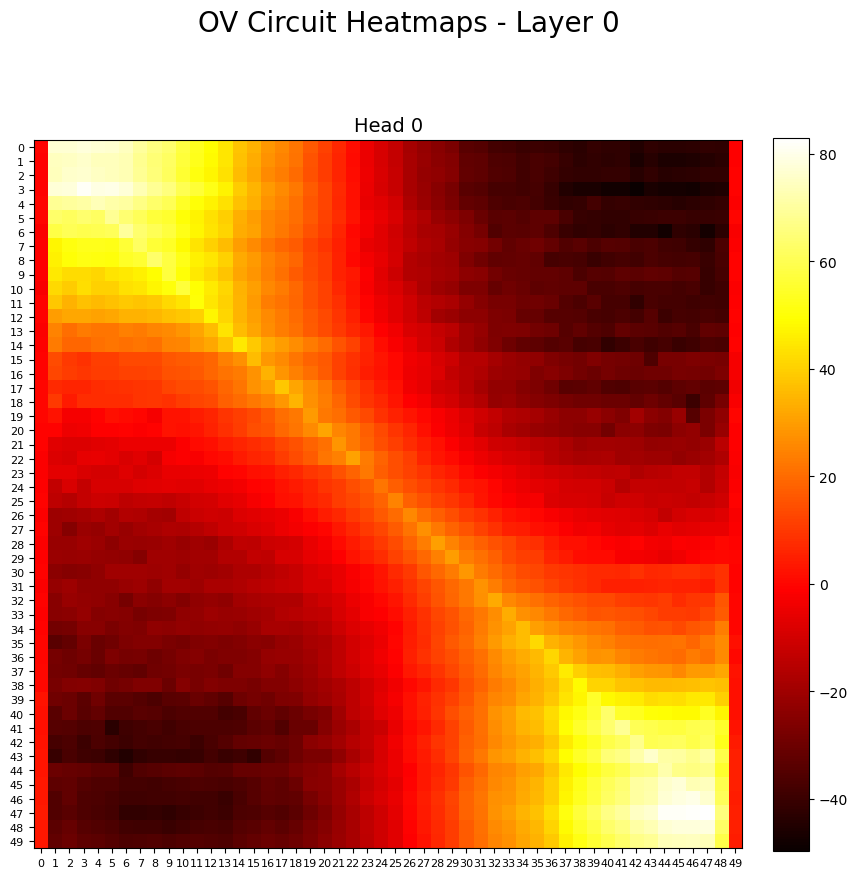

In [15]:
plot_ov_heatmap_all_heads(model, layer=0, pos=-1)


Axes(0.125,0.11;0.775x0.77)


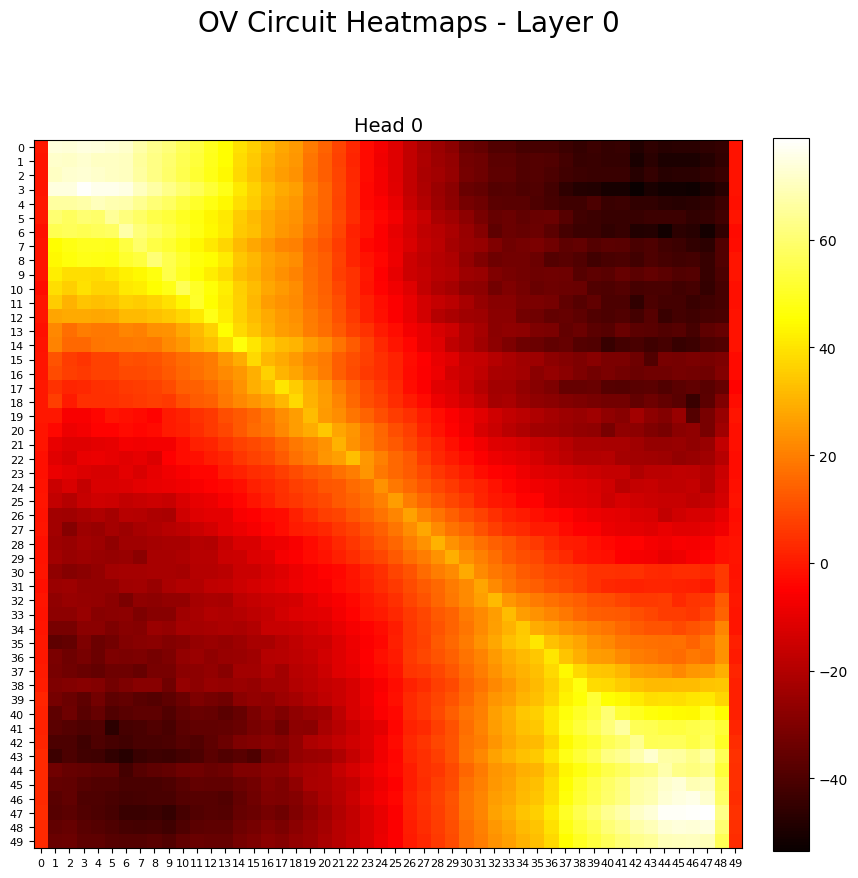

In [16]:
plot_ov_heatmap_all_heads(model, layer=0, pos=5)


#### OV Circuit Analysis and General Conclusion

I must say, this is the most interesting yet most challenging part of interpreting the model. This is also why I am not entirely confident in my interpretation, but I will try to explain my thoughts.

In the QK circuit, we observed that the model focuses more on numbers close to the center and less on numbers near the edges. The OV circuit, in turn, should reveal how the model uses this information and how propagation occurs.

The OV circuit appears to be quite strict regarding positional information, relying heavily on token values rather than their positions. This is why, even when we removed or altered the positional information in the circuit, the visualization did not change significantly.

From a simple observation, we can identify two distinct structures in the OV circuit. The first is a diagonal brightness, indicating some sort of strict copying or propagation. The second is localized brightness in the top-left and bottom-right corners (or, alternatively, the edges of our range), accompanied by darkness at the opposite edges, which may represent negative values.

Based on these observations, we can infer that when the model attends to a token 
𝑋, if 𝑋 is close to the edges, it doesn't solely propagate its own information but also incorporates information from nearby tokens. However, if 𝑋 is near the center, it directly copies its own information.

Now, for my interpretation of the model: I believe the model makes a statistical guess for median by strictly copying the numbers near the center. Then numbers near the edges seem to adjust this guess by either pulling it up or down. This interpretation is based on my observation of brightness at the edges and darkness at the opposite edges. Simply put, if most numbers in the list are closer to the upper range (e.g., 50), the model is likely to predict a value near 50. Conversely, if the numbers are closer to the lower range (e.g., 0), the model predicts a value near 0. If there are numbers close to both the upper and lower ranges, the opposing brightness and darkness seem to cancel each other out, leading the model to predict a value near the center.

I hope this interpretation is correct, and I hope you enjoyed the notebook. Thank you for reading.


Note: Although the model's performance on both the training and validation sets is very high, I don't believe the model is stable enough. I tried other combinations for training (e.g., more data, additional heads, longer sequences, etc.), and they seemed to result in architectures with different dominant patterns, such as more pronounced diagonals. Nonetheless, I think this model serves as a good example of how even a simple model can learn complex patterns.